## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [75]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pprint import pprint
from src import calibration, utils, detection

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Camera Calibration

* camera calibrated
* chess-board image can be undistorted
* perspective transform can be applied to chess-board image
* perspective transform applied to road image

In [76]:
camera = calibration.Camera()
camera.calibrate(False)

WARNING Not all corners were found in camera_cal/calibration5.jpg, skipping...
WARNING Not all corners were found in camera_cal/calibration4.jpg, skipping...
WARNING Not all corners were found in camera_cal/calibration1.jpg, skipping...


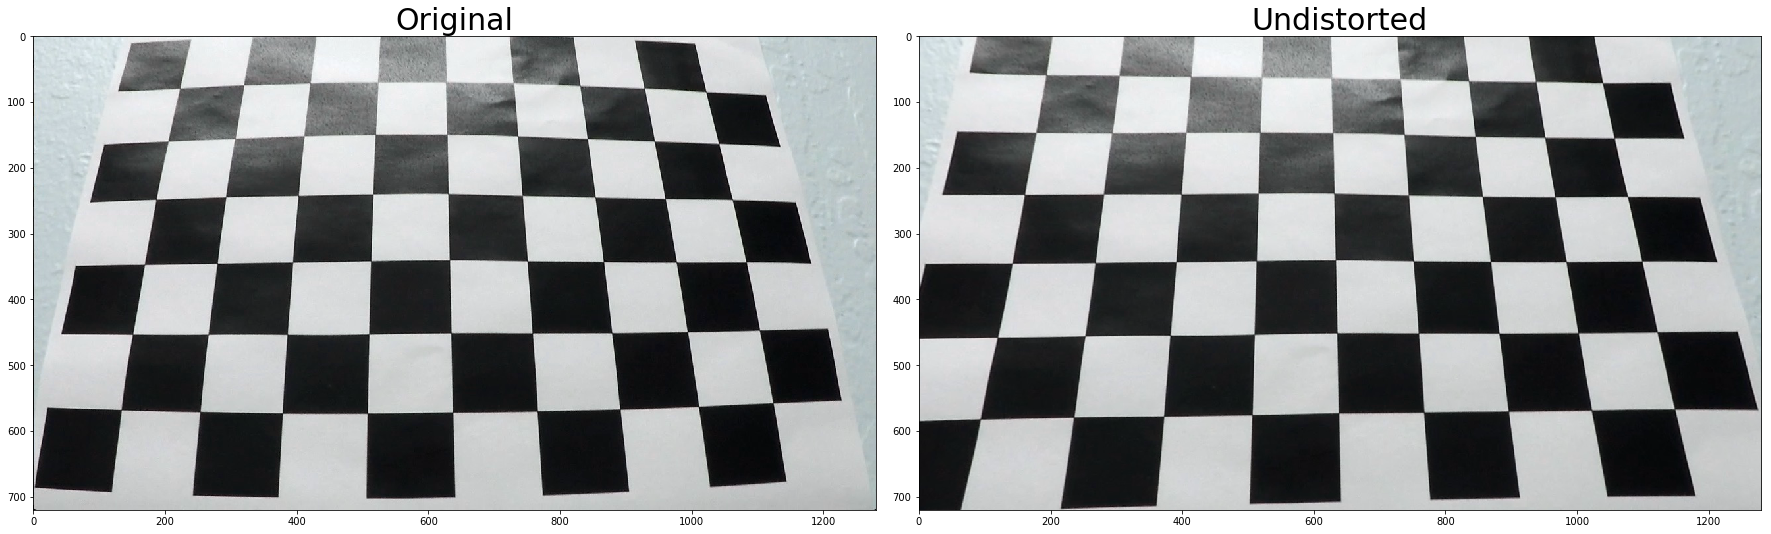

In [77]:
image_filename = 'examples/chess-board.jpg'
img = cv2.imread(image_filename)

undistorted = camera.undistort(img)

utils.plot_images([(img, 'Original'), (undistorted, 'Undistorted')])

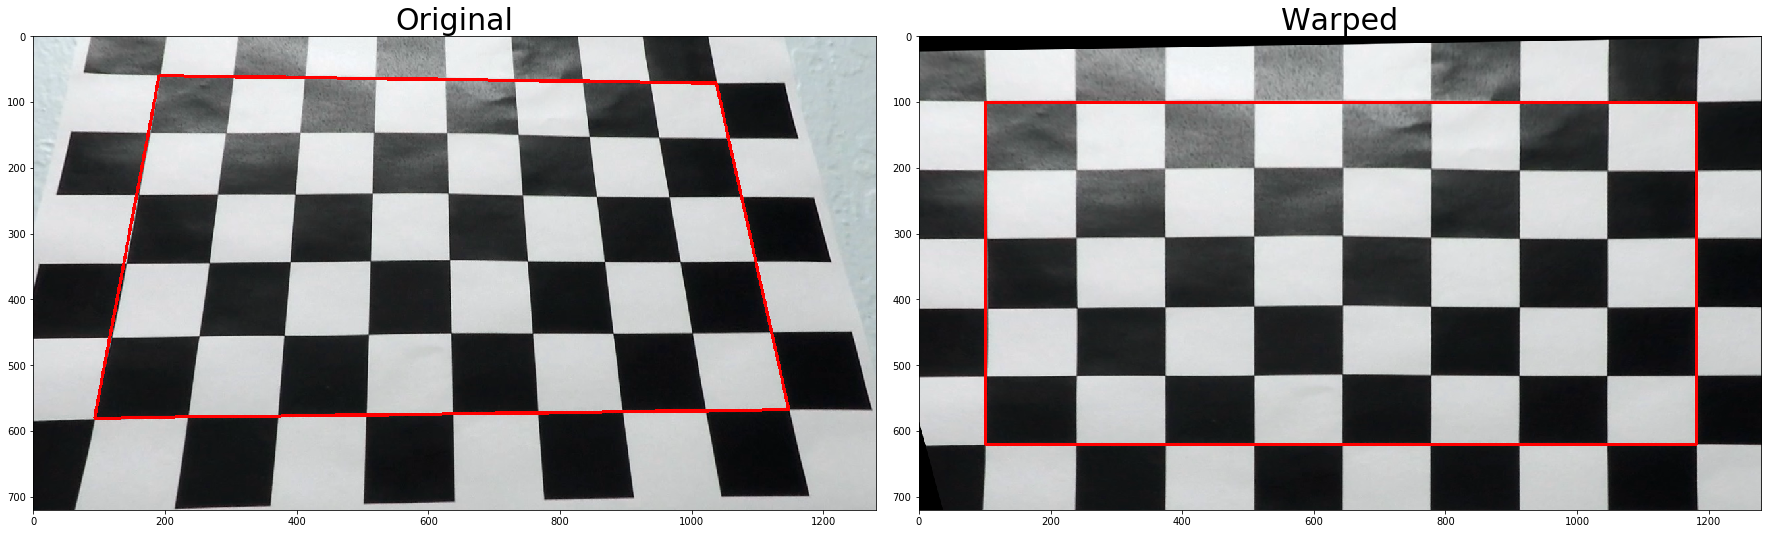

In [78]:
image_filename = 'examples/chess-board.jpg'
img = cv2.imread(image_filename)

src, dst = camera.find_chess_board_perspective_transform_pts(img, 100)
overlaid, warped, _ = camera.perform_perspective_transform(img, src, dst)

utils.plot_images([(overlaid, 'Original'), (warped, 'Warped')])

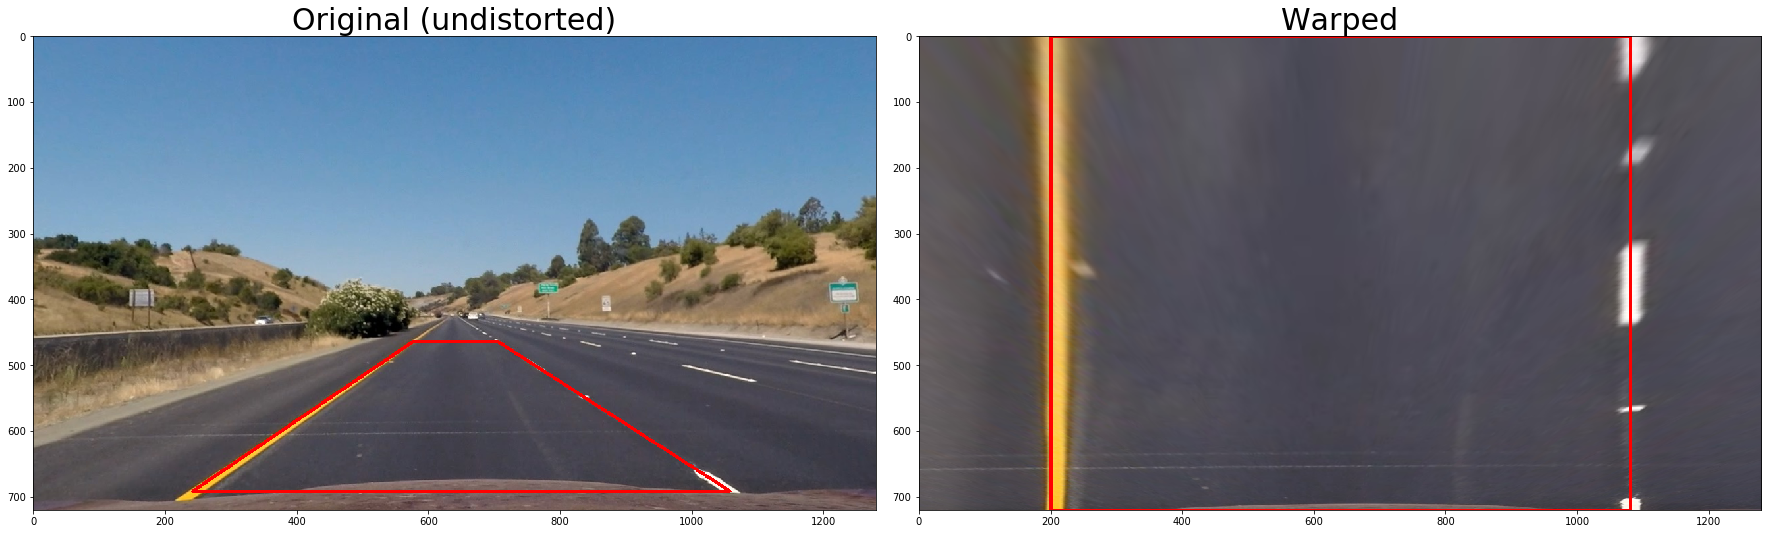

In [79]:
image_filename = 'examples/straight_lines1.jpg'
img = mpimg.imread(image_filename)

lane_corners_from_undistorted_image = [[242,691], [1058, 691], [706, 464], [576, 464]]
dst = utils.rectangle_pts_inside_image(img, x_offset=200)

overlaid, warped, lanes_perspective_mat = camera.perform_perspective_transform(img, lane_corners_from_undistorted_image, dst)

utils.plot_images([(overlaid, 'Original (undistorted)'), (warped, 'Warped')])

(151289.19769261999, 5813.7902093636767)
(2257.5968114893162, 3745.896215028471)
(5465.9417068423763, 3392.6799408897491)
(35989.867830398165, 724.43115222293159)
(1997.8422946642927, 10306.324654999498)


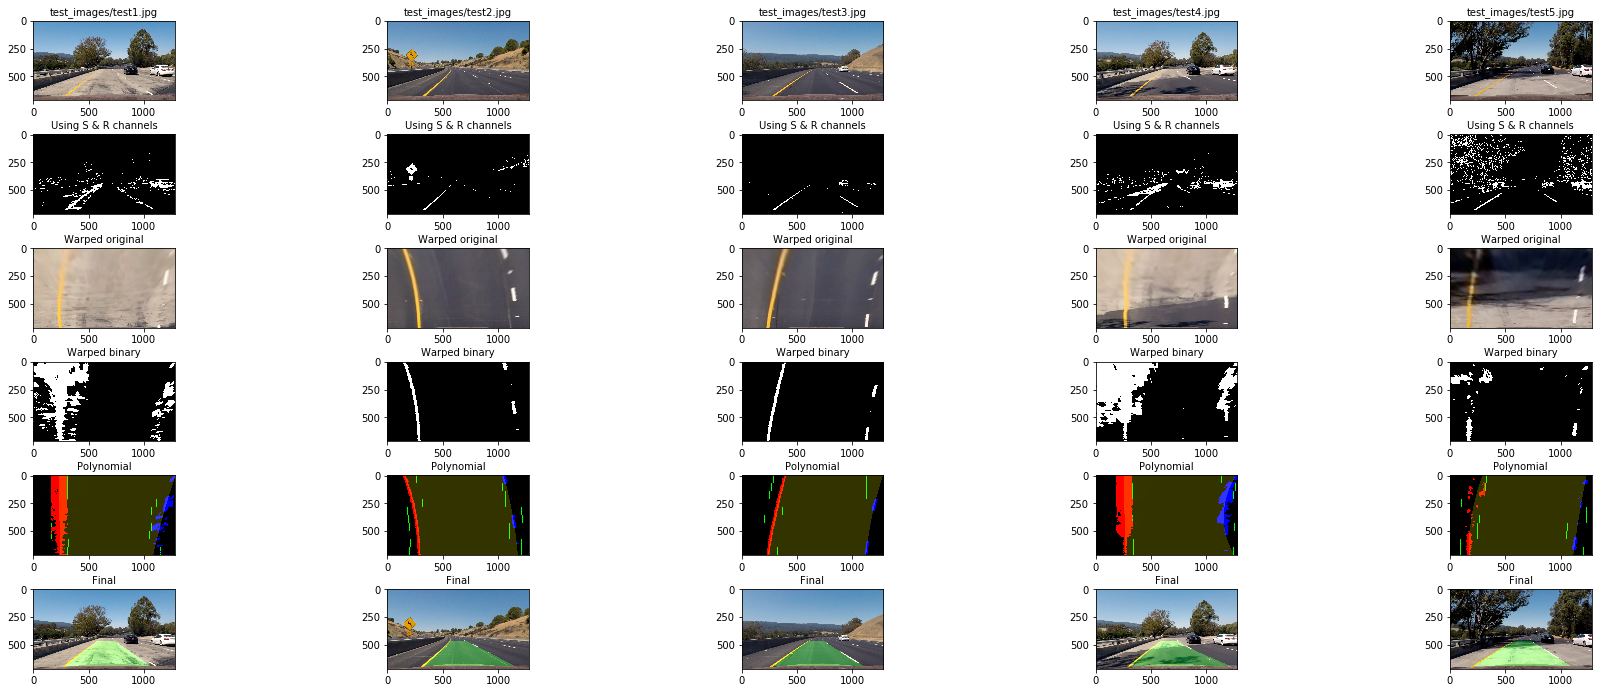

In [81]:

img_paths = ['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg',  'test_images/test4.jpg',  'test_images/test5.jpg']

results = []
for ip in img_paths:
    raw_filename = 'output_images/' + os.path.basename(os.path.basename(ip))
    
    img = mpimg.imread(ip)
    
    # Perform thresholding    
    s_binary, _ = detection.apply_thresholds(img, cv2.COLOR_RGB2HLS, 2, (175, 255), (15, 50))
    r_binary, _ = detection.apply_thresholds(img, None, 0, (205, 255), (15, 100))
    binary = s_binary | r_binary
    mpimg.imsave(raw_filename + '.1.binary.jpg', binary)

    # Warp the image     
    warped_orig = camera.warp_image(img, lanes_perspective_mat)
    warped_binary = camera.warp_image(binary, lanes_perspective_mat)
    mpimg.imsave(raw_filename + '.2.warped_binary.jpg', warped_binary)
    mpimg.imsave(raw_filename + '.2.warped_orig.jpg', warped_orig)
    
    # Fit the polynomial
    _,_,_,_,sliding_windows = detection.find_lane_pixels(warped_binary)
    left_fit, left_fitx, right_fit, right_fitx, ploty, polynomial = detection.fit_polynomial(warped_binary)
    mpimg.imsave(raw_filename + '.3.polynomial.jpg', polynomial)

    # Measure curvature
    curvature = detection.measure_curvature(left_fit, right_fit, ploty)
    print(curvature)
    
    # Visualize lanes in original image
    inv_perspective_mat = np.linalg.inv(lanes_perspective_mat)
    final = detection.overlay_lanes(warped_binary, left_fitx, right_fitx, ploty, inv_perspective_mat, img, camera.undistort(img))
    mpimg.imsave(raw_filename + '.4.final.jpg', final)
    
    # Assemble everything together      
    results.append([
        (img, ip), 
        (binary, 'Using S & R channels'),
        (warped_orig, 'Warped original'),
        (warped_binary, 'Warped binary'), 
        (polynomial, 'Polynomial'),
        (final, 'Final')
                   
    ])

    
utils.plot_images(results)